Analyzing one MeetUp is straightforward, and we don't realize many of the benefits of graph theory measures. Now, let's look at a more complex network: the entire Nashville MeetUp scene. 

We'll still focus on our Pythonistas, but instead of looking at who holds PyNash together ("the glue guys / girls"), we'll look at who connects PyNash to the rest of Nashville.

1. Load in and tailor the MeetUp RSVP data.
2. Create a *member-to-member* graph from the *member-to-group* data.
3. Use network metrics to determine member importance.
4. Visualize Nashville MeetUp communities.

### 1. Load in and tailor the MeetUp RSVP data.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

# Read in metadata
members = pd.read_csv('data/members.csv', index_col='member_id')
groups = pd.read_csv('data/groups.csv', index_col='group_id')
events = pd.read_csv('data/events.csv', index_col='event_id')

# Read in edge data
rsvps = pd.read_csv('data/rsvps.csv')

# Identify PyNash members 
pynash_events = events.loc[events.group_urlname == 'PyNash'].index
pynash_member_ids = rsvps.loc[rsvps.event_id.isin(pynash_events), 'member_id'].unique()

In [2]:
print("There are {} unique members and {} unique events.".format(len(rsvps.member_id.unique()), 
                                                                 len(rsvps.event_id.unique())))

There are 24631 unique members and 19031 unique events.


We want to be a little more particular about how we create this graph, because we have a much larger amount of data than previously. We are also likely less interested in *event attendance* than we are in *group membership*, so let's make a few changes.

- Group RSVPs by MeetUp group
    - Edges will be the number of events attended in a group.
- Threshold membership at at least 2 events to get rid of people who are brand new

In [3]:
# Map event_id --> group_urlname --> group_id
eid2gurl = events.group_urlname.to_dict()
gurl2gid = {v: k for k, v in groups.group_urlname.to_dict().items()}
eid2gid = {k: gurl2gid[v] for k, v in eid2gurl.items()}
rsvps['group_id'] = [eid2gid[x] for x in rsvps.event_id]

# Group by group and threshold
rsvps_group = (rsvps.groupby(['member_id', 'group_id']).size()
                   .reset_index().rename(columns={0: 'weight'}) )
rsvps_group['membership'] = rsvps_group.weight > 1

n_filt, n_keep = rsvps_group.membership.value_counts().values
print('{} members had only attended one event in a group. \n{} members are returning visitors.'.format(n_filt, n_keep))

27588 members had only attended one event in a group. 
17995 members are returning visitors.


In [4]:
# Build Nashville MeetUp graph
g = nx.from_pandas_dataframe(rsvps_group.loc[rsvps_group.membership==True], 
                             'member_id', 'group_id', ['weight'])
node_type_dict = {n: ('member' if n in members.index else 'group') 
                        for n in g.nodes}
nx.set_node_attributes(g, node_type_dict, 'node_type')

# Print summary of nodes
print('The graph has...')
print('{} members'.format(len([n for n in g.nodes if g.nodes[n]['node_type'] == 'member'])))
print('{} groups'.format(len([n for n in g.nodes if g.nodes[n]['node_type'] == 'group'])))

The graph has...
11500 members
517 groups


### 2. Create a *member-to-member* graph from the *member-to-group* data.

##### Connected components
One issue we must watch out for is a disconnected graph, where not all nodes are connected. This might happen, for example, if a MeetUp group was a small, special-interest group that did not attract new people. 

NetworkX has some function to handle this situation. First, we can test for connectivity.

In [5]:
nx.is_connected(g)

False

We need to accommodate this somehow. Let's see if there are just a few disconnected nodes.

In [6]:
components = nx.connected_components(g)
components = sorted(list(components), key=len)
component_lengths = [len(x) for x in components]

In [7]:
print('There are {} connected component graphs.'.format(len(components)))
print('The three largest have {}, {} and {} edges.'.format(component_lengths[-3], component_lengths[-2], component_lengths[-1]))

There are 58 connected component graphs.
The three largest have 13, 15 and 11828 edges.


You can see that the vast majority of the graph is connected, with many smaller disconnected fragments. We'll just take the top component and go on our way.

In [8]:
g = nx.subgraph(g, components[-1])

##### Project bipartite graph

Just as in our bipartite example, we need to project the (member, group) graph to a (member, member) graph. We can get the subset of member_nodes using `nx.bipartite.sets` and then use `weighted_projected_graph` to create the member-member connections.

In [10]:
assert nx.is_bipartite(g) == True

member_nodes, group_nodes = nx.bipartite.sets(g)
gm = nx.bipartite.weighted_projected_graph(g, member_nodes, ratio=False)

Excellent! We now have a graph with member-to-member connections, where edges represent shared group membership. These people are likely to have run into each other before, or at least to be interested in the same types of things. 

### 3. Use network metrics to determine member importance.


We're going to look at just a few measures:

- **Degree**: the number of individuals a person shares in a group with. This will be higher for people who are part of big groups.
- **Clustering**: the amount of "triangling" in the graph, or the likelihood a person's connections will be connections. High clustering is common in "sub-communities". For example, two people interested in tech are more likely to know each other than one person interested in tech and another in real estate.
- **Centrality**: the relative importance of an individual in "connecting" the network. High centrality means that a person can connect people from different communities in the network. 

In [25]:
def get_graph_measures(centrality_subset_ratio=0.25):
    # Initialize our dataframe
    df = pd.DataFrame(index=gm.nodes)
    df['in_pynash'] = [True if n in pynash_member_ids 
                                   else False for n in gm.nodes]

    # Add in "group" degree from the original graph
    df['num_groups'] = pd.Series(dict(nx.degree(g, member_nodes)))

    # Get member-graph measures
    df['degree'] = pd.Series(dict(nx.degree(gm)))
    df['clustering'] = pd.Series(nx.clustering(gm))

    # Centrality, especially betweenness centrality, is an intensive calculation
    subset_size = np.floor(centrality_subset_ratio * len(g.nodes)).astype(int)
    centrality = nx.betweenness_centrality(gm, k=subset_size, weight='weight')
    df['centrality'] = pd.Series(centrality)

    # Save the member information, since it takes so long to calculate
    df.to_csv('data/nashville_graph_data.csv', encoding='utf8')
    
    return df

overwrite = False
if overwrite == True:
    df_members = get_graph_measures(0.25)
if overwrite == False:
    df_members = pd.read_csv('data/nashville_graph_data.csv', index_col='member_id')


The pair-plot from the Seaborn library is a great way to visualize multiple variables at once. Let's use it to look at our complete graph.

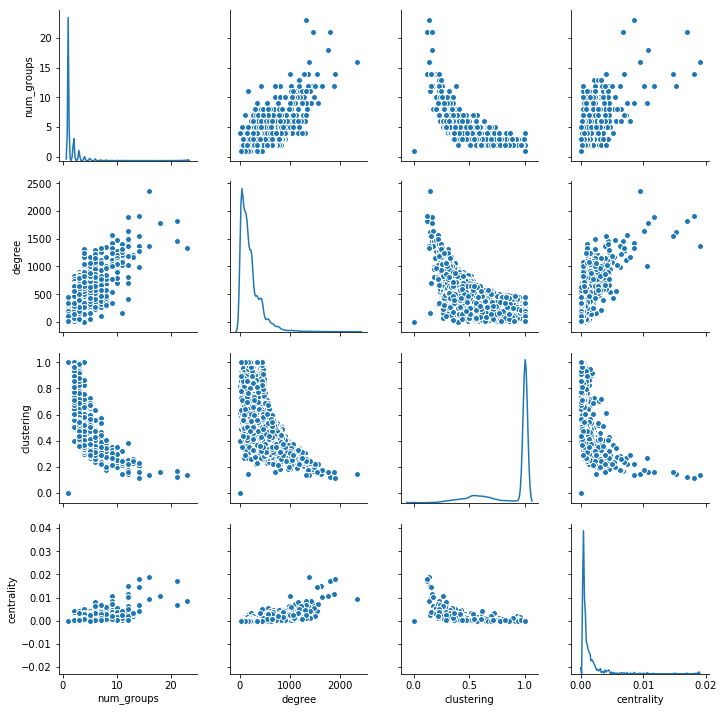

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns 

sns.pairplot(df_members, vars=['num_groups', 'degree', 'clustering', 'centrality'],
             diag_kind='kde')

plt.show()

We can see that, as in PyNash, there are a few highly central people across Nashville, and that these people also tend to have a very high degree. However, the relationship is a little weaker: there are many people with a very high degree that have limited centrality, because they are not connecting "disparate" people - only people who are already connected.

Let's take a look at how our PyNash folk fare.

In [28]:
def print_group_report(member_id,  num_groups=5):
    '''Prints a brief report of a members group affiliations.'''
    gdict = {targ: attr['weight'] for src,targ,attr in g.edges(member_id, data=True)}
    gdf = (pd.DataFrame.from_dict(gdict, orient='index')
               .rename(columns={0: 'events_attended'})
               .join(groups).sort_values(by='events_attended', ascending=False) )

    gdf[['group_name', 'events_attended']]
    
    report_str = '{} ({}) is a member of {} groups.\n'.format(members.loc[member_id, 'name'], member_id, gdf.shape[0])
    report_str += 'Their top attendance rates are:\n'
    max_groups = num_groups if (gdf.shape[0] >= num_groups) else gdf.shape[0]
    for ind, s in gdf.iloc[0:max_groups].iterrows():
        report_str += '- {}: {}\n'.format(s.group_name, s.events_attended)
        
    print(report_str)

In [29]:
pynash_top_ten = (df_members.loc[df_members.in_pynash==True]
                    .sort_values(by='centrality', ascending=False)
                    .join(members['name']).iloc[0:10]
                    [['name', 'num_groups', 'degree', 'clustering', 'centrality']] )
pynash_top_ten

,name,num_groups,degree,clustering,centrality
member_id,,,,,
197928971,Ted,12,1620,0.143080,0.015200
175300482,Rav,14,1556,0.159742,0.014787
221191725,Omar Ali,12,1893,0.161997,0.011639
43237102,Hameed Gifford,6,1167,0.289286,0.007896
187254868,Andrew Clement,9,1568,0.219833,0.007346
206481851,Adia Tigney,14,1277,0.226663,0.006861
11872972,Alan,12,1374,0.175181,0.006322
183015093,Morgan,6,985,0.285514,0.006256
73895512,Angela Howard,8,1076,0.233035,0.004925


Nice! Among our attendees are some very connected people. Look at how these highly connected people are a part of different groups, not just "tech" groups. Rav, for example, attends UX, film-making and songwriting MeetUps.

In [30]:
print_group_report(175300482, 8)

Rav (175300482) is a member of 14 groups.
Their top attendance rates are:
- Nashville UX: 10
- Nashville Filmmakers: 7
- Nashville Product Meetup: 7
- Design Thinking Nashville: 6
- The Nashville Songwriters Meetup Group: 3
- WordPress Nashville: 3
- 20s in Nashville: 3
- The Nashville Singer, Musician and Songwriter Meetup Group: 2



What about in all of Nashville? Who are you most likely to know?

In [31]:
nash_top_ten = (df_members.sort_values(by='centrality', ascending=False)
                    .join(members['name']).iloc[0:10]
                    [['name', 'degree', 'clustering', 'centrality']] )
nash_top_ten

,name,degree,clustering,centrality
member_id,,,,
3949436,Pablo,1377,0.134299,0.019059
8539046,Shalini,1911,0.116845,0.018181
5900662,Matt Kenigson,1811,0.121181,0.016951
197928971,Ted,1620,0.143080,0.015200
175300482,Rav,1556,0.159742,0.014787
221191725,Omar Ali,1893,0.161997,0.011639
81924252,Theresa,1775,0.160981,0.010717
144256692,David VanWie,1002,0.266855,0.010668
46486792,Michelle McManus,1642,0.174441,0.010115


In [32]:
print_group_report(3949436, 8)

Pablo (3949436) is a member of 16 groups.
Their top attendance rates are:
- Eat Love Nash: 9
- Nashvegans!: 6
- 20&UP Tennis: Nashville: 6
- Nashville Spanish Meetup: 5
- Spiritual Psychology and Consciousness Group: 5
- Nashville Pilgrimage Hiking & Walking Meetup Group: 5
- The Joy of Dining Out with Friends Meetup: 4
- Nashville Tennis Meetup: 4



### 4. Visualize Nashville MeetUp communities.

In [154]:
gg = nx.bipartite.weighted_projected_graph(g, group_nodes, ratio=False)

# Create groups dataframe
df_groups = pd.DataFrame(index=gg.nodes)
df_groups['num_members'] = pd.Series(dict(nx.degree(g, group_nodes)))
df_groups['degree'] = pd.Series(dict(nx.degree(gg)))
df_groups['clustering'] = pd.Series(nx.clustering(gg, weight='weight'))
df_groups['centrality'] = pd.Series(nx.betweenness_centrality(gg, weight='weight'))

df_groups = df_groups.join(groups[['group_name', 'category_name']])

In [155]:
ten_most_central = (df_groups.sort_values(by='centrality', ascending=False)
                        .iloc[0:10])
print('The ten most inter-connected groups are: ')
for ii, s in ten_most_central.iterrows():
    print('- {} ({})'.format(s.group_name, s.category_name))

The ten most inter-connected groups are: 
- Stepping Out Social Dance Meetup (Dancing)
- What the Pho! (Food & Drink)
- Middle TN 40+ singles (Singles)
- Eat Love Nash (Socializing)
- Nashville Networking Business Luncheon (Career & Business)
- Nashville Hiking Meetup (Outdoors & Adventure)
- 20s in Nashville (Socializing)
- Sunday Assembly Nashville (Religion & Beliefs)
- Nashville Online Entrepreneurs (Career & Business)
- Tennessee Hiking Group (Outdoors & Adventure)


In [71]:
ten_most_clustered = (df_groups.loc[df_groups.num_members>20]
                          .sort_values(by='clustering', ascending=False)
                          .iloc[0:10] )
print('The ten most clustered groups are: ')
for ii, s in ten_most_clustered.iterrows():
    print('- {} ({})'.format(s.group_name, s.category_name))

The ten most clustered groups are: 
- R-Ladies Nashville (Career & Business)
- Nashville Software Automation Professionals (Tech)
- Nashville API Developers (Tech)
- freeCodeCamp Nashville (Tech)
- The Nashville TENNISseans (Sports & Recreation)
- Nashville Dungeon Delvers (Games)
- Music City Drinking Buddies (Socializing)
- Nashville CocoaHeads (Tech)
- State & Local Government Developers Network (Tech)
- Nashville Spiritual Experiences Group (New Age & Spirituality)


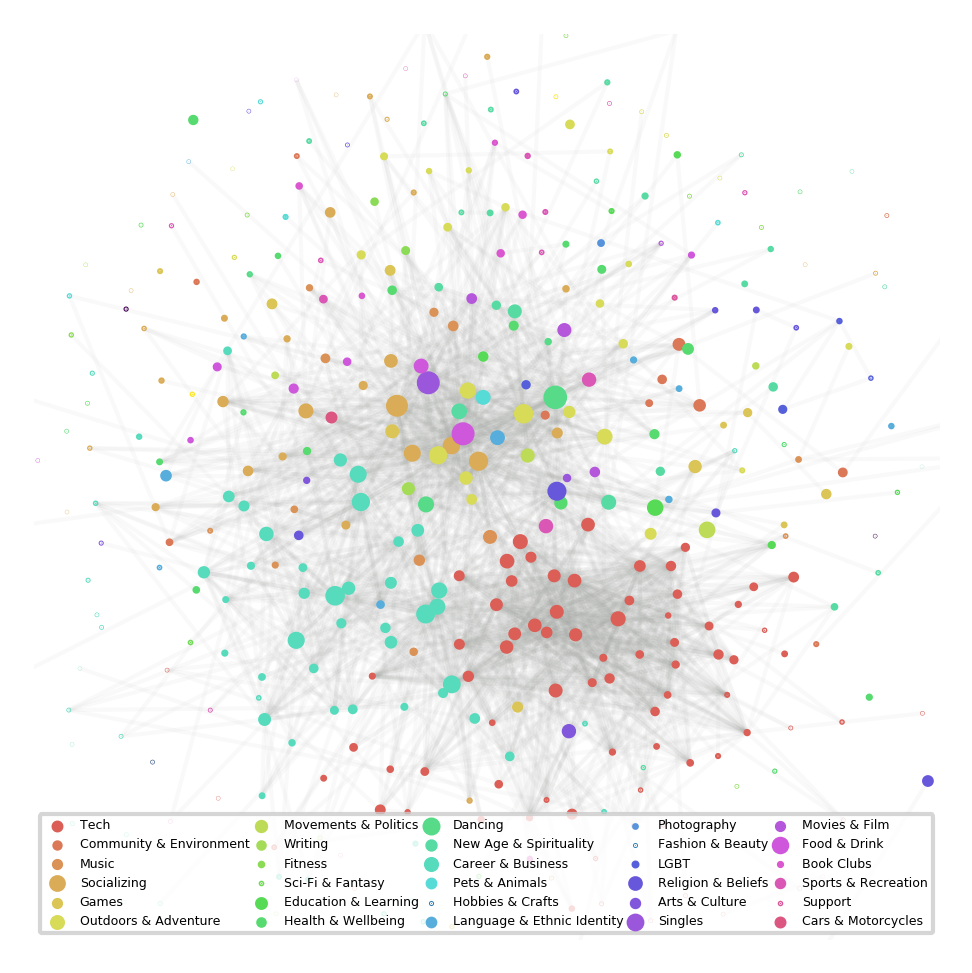

In [167]:
from utils import setup_graph_plot

fig, ax = setup_graph_plot(dpi=300)

# Set colors for the graph based on Category name
categories = df_groups.category_name.unique().tolist()
palette = sns.color_palette('hls', len(categories))
color_dict = {}
for ii, cat in enumerate(categories):
    color_dict[cat] = palette[ii]        

gg_small = gg.subgraph([n for n in gg.nodes if gg.degree[n] > 2])
#pos = nx.kamada_kawai_layout(gg_small, scale=1)
for cat in categories:
    node_set = df_groups.loc[df_groups.category_name==cat].index.tolist()
    node_set = [n for n in node_set if n in gg_small.nodes]
    sizes = [500 * df_groups.loc[n, 'centrality'] for n in node_set]
    nx.draw_networkx_nodes(gg_small, pos, nodelist=node_set, node_size=sizes, 
                           node_color=color_dict[cat], label=cat)
nx.draw_networkx_edges(gg_small, pos, 
                       edgelist=[(s,t) for s,t,d in gg_small.edges(data=True) if d['weight'] > 1],
                       edge_color='xkcd:gray', alpha=0.05)

w = 0.7
ax.set_xlim([-w, w])
ax.set_ylim([-w, w])

plt.legend(loc='lower center', fontsize=3, mode='expand', ncol=5)

plt.show()